In [7]:
%load_ext autoreload
%autoreload 2
import n_fct_t_rl_thm_ll as bond_create
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
#choose country
country = 882

#number of simulated years
r = 10000

#define maximum and minimum return periods to be covered
lower_share = 0.045
upper_rp = 250

target_sharpe = 0.5
rf_rate = 0.0

cc_models = ["CMCC", "CNRM", "ECEARTH", "HADGEM"]

OUTPUR_DIR = Path("C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/hazard")
STORM_DIR = Path("C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/hazard/tc_tracks/storm_tc_tracks/climate_change")

In [10]:
bond_metrics_dic = {}
bond_returns_dic = {}
premium_dic_dic = {}
nominal_dic = {}
pay_dam_df_dic = {}
es_metrics_dic = {}
int_grid_dic = {}
imp_per_event_flt_dic = {}
imp_admin_evt_flt_dic = {}
ann_losses_dic = {}

bond_metrics_dic['CRCL'], bond_returns_dic['CRCL'], premium_dic_dic['CRCL'], nominal_dic['CRCL'], pay_dam_df_dic['CRCL'], es_metrics_dic['CRCL'], int_grid_dic['CRCL'], imp_per_event_flt_dic['CRCL'], imp_admin_evt_flt_dic['CRCL'], ann_losses_dic['CRCL'] = bond_create.sng_cty_bond(country, prot_rp=upper_rp, to_prot_share=lower_share)

for mod in cc_models:
    bond_metrics, bond_returns, premium_dic, nominal, pay_dam_df, es_metrics, int_grid, imp_per_event_flt, imp_admin_evt_flt, ann_losses = bond_create.sng_cty_bond_cc(country, cc_model=mod, prot_share=0.289, to_prot_share=lower_share, output_dir=OUTPUR_DIR, storm_dir=STORM_DIR)

    bond_metrics_dic[mod] = bond_metrics
    bond_returns_dic[mod] = bond_returns
    premium_dic_dic[mod] = premium_dic
    nominal_dic[mod] = nominal
    pay_dam_df_dic[mod] = pay_dam_df
    es_metrics_dic[mod] = es_metrics
    int_grid_dic[mod] = int_grid
    imp_per_event_flt_dic[mod] = imp_per_event_flt
    imp_admin_evt_flt_dic[mod] = imp_admin_evt_flt
    ann_losses_dic[mod] = ann_losses


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\exposures_alt.py:91: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  islands_gdf = gpd.GeoDataFrame({'geometry': [islands_gdf]}, crs=crs).explode()


Number of tracks in SP basin: 713
The principal of the cat bond is: 251308348.279 [USD]
Principal as share of GDP: 0.289


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\exposures_cc.py:93: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  islands_gdf = gpd.GeoDataFrame({'geometry': [islands_gdf]}, crs=crs).explode()


Number of tracks in SP basin: 2708
The principal of the cat bond is: 251111625.539 [USD]
Principal as share of GDP: 0.289


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\exposures_cc.py:93: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  islands_gdf = gpd.GeoDataFrame({'geometry': [islands_gdf]}, crs=crs).explode()


Number of tracks in SP basin: 4133
The principal of the cat bond is: 251111625.539 [USD]
Principal as share of GDP: 0.289


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\exposures_cc.py:93: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  islands_gdf = gpd.GeoDataFrame({'geometry': [islands_gdf]}, crs=crs).explode()


Number of tracks in SP basin: 3188
The principal of the cat bond is: 251111625.539 [USD]
Principal as share of GDP: 0.289


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\exposures_cc.py:93: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  islands_gdf = gpd.GeoDataFrame({'geometry': [islands_gdf]}, crs=crs).explode()


Number of tracks in SP basin: 2718
The principal of the cat bond is: 251111625.539 [USD]
Principal as share of GDP: 0.289


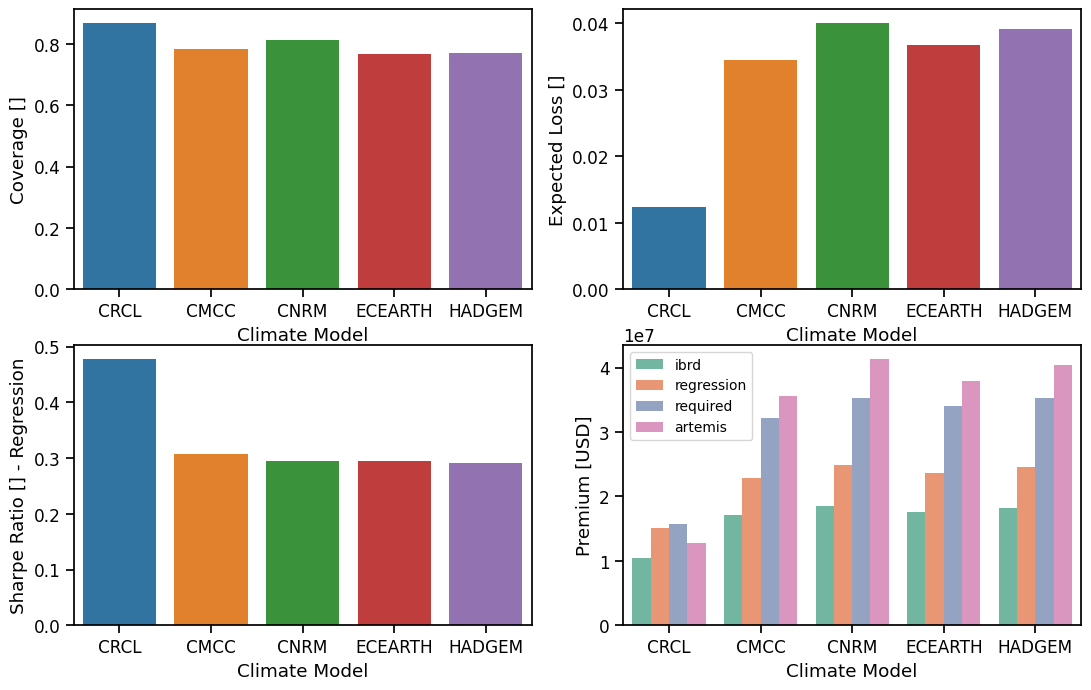

In [79]:
tc_sets = ["CRCL", "CMCC", "CNRM", "ECEARTH", "HADGEM"]
tc_sets_rep = [item for item in tc_sets for _ in range(4)]
cc_cond = ["Present Climate", "Climate Change", "Climate Change", "Climate Change", "Climate Change"]

cc_coverage = []
prem_data = []
cc_exp_loss = []
cc_sharpe = []
for i, mod in enumerate(tc_sets):
    cc_coverage.append(bond_metrics_dic[mod]['Coverage'][0])
    cc_exp_loss.append(premium_dic_dic[mod]['exp_loss'])
    cc_sharpe.append(bond_metrics_dic[mod]['Sharpe_ratio_ann'][1])
    prem_data.append({"Climate Condition": cc_cond[i], "Premium Type": "ibrd", "Premium [USD]": premium_dic_dic[mod]['ibrd'] * nominal_dic[mod]})
    prem_data.append({"Climate Condition": cc_cond[i], "Premium Type": "regression", "Premium [USD]": premium_dic_dic[mod]['regression'] * nominal_dic[mod]})
    prem_data.append({"Climate Condition": cc_cond[i], "Premium Type": "required", "Premium [USD]": premium_dic_dic[mod]['required'] * nominal_dic[mod]})
    prem_data.append({"Climate Condition": cc_cond[i], "Premium Type": "artemis", "Premium [USD]": premium_dic_dic[mod]['artemis'] * nominal_dic[mod]})

cc_coverage = np.array(cc_coverage).flatten()
cc_exp_loss = np.array(cc_exp_loss).flatten()
cc_sharpe = np.array(cc_sharpe).flatten()
prem_data = pd.DataFrame(prem_data)
prem_data['Climate Model'] = tc_sets_rep

df_coverage = {'Coverage []': cc_coverage, 'Climate Condition': cc_cond, 'Climate Model': tc_sets}
df_exp_loss = {'Expected Loss []': cc_exp_loss, 'Climate Condition': cc_cond, 'Climate Model': tc_sets}
df_sharpe = {'Sharpe Ratio [] - Regression': cc_sharpe, 'Climate Condition': cc_cond, 'Climate Model': tc_sets}

fig, axes = plt.subplots(2, 2, figsize=(13, 8))
ax1, ax2, ax3, ax4 = axes.ravel() 
marker_types = ['o','s', '^']
sns.set_context("notebook", font_scale=1.1)
sns.barplot(y='Coverage []', x='Climate Model', data=df_coverage, ax=ax1, hue='Climate Model', legend=False)
sns.barplot(y='Expected Loss []', x='Climate Model', data=df_exp_loss, ax=ax2, hue='Climate Model', legend=False)
sns.barplot(y='Sharpe Ratio [] - Regression', x='Climate Model', data=df_sharpe, ax=ax3, hue='Climate Model', legend=False)
palette = sns.color_palette("Set2", n_colors=prem_data['Premium Type'].nunique())
sns.barplot(y='Premium [USD]', x='Climate Model', data=prem_data, ax=ax4, hue='Premium Type', palette=palette)
ax4.legend(fontsize=10)